# End-to-End Machine Learning task

This notebook create new features and mesures the the perfomance change in the model. The goal is to create features to increase the model performance.

In [246]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Import the data

In [247]:
# Read the data to a pandas data frame
df = pd.read_csv('original_apartment_data_analytics_hs24_with_lat_lon.csv', sep=',', encoding='utf-8')
# Get number of rows and columns
df.shape

(819, 18)

In [248]:
df.columns

Index(['bfs_number', 'rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y'],
      dtype='object')

## Model Performance

In [249]:
def model_performance(features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    X, y = df[features], df['price']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [250]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [ -964.  -746.  -775. -1109.  -880.]
Mean RMSE: -894.8


## Data Cleaning
- Remove apartments with empty columns
- Remove apartments which price exceeds 6000.-
- Remove apartments which price is lower than 1000.-

In [251]:
print('Total apartment before data cleaning:', len(df))

# Remove missing values
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 6000)]

print('Total apartment after data cleaning:', len(df))

Total apartment before data cleaning: 819
Total apartment after data cleaning: 778


In [252]:
# Before data cleaning Mean RMSE: -894.8

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [-735. -546. -769. -544. -588.]
Mean RMSE: -636.4


## Feature engineering

### Create additional variables from the apartment's descriptions

In [253]:
# Create the new variable
df['room_per_m2'] = round(df['area'] / df['rooms'], 2)
df['price_per_m2'] = round(df['price'] / df['area'], 2)

In [254]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2']
model_performance(features, df)

CV results RMSE: [-738. -550. -772. -509. -590.]
Mean RMSE: -631.8


In [255]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'price_per_m2']
model_performance(features, df)

CV results RMSE: [-189. -131. -286. -174. -183.]
Mean RMSE: -192.6


#### Create new categorical variable based on apartment area

In [256]:
labels = ['0 - 49', '50 - 99', '100 - 500']
df["area_cat"] = pd.cut(df.area, bins=[0, 50, 100, 500], labels=labels)
df[['area', 'area_cat']].head(10)

,area,area_cat
0,49,0 - 49
1,111,100 - 500
2,58,50 - 99
3,118,100 - 500
4,66,50 - 99
5,61,50 - 99
6,65,50 - 99
7,101,100 - 500
8,68,50 - 99
9,191,100 - 500


In [257]:
from sklearn.preprocessing import OrdinalEncoder

area_cat = df['area_cat'].values.reshape(-1,1)
ordinal_encoding = OrdinalEncoder()
area_cat_encoded = ordinal_encoding.fit_transform(area_cat) 

df['area_cat_ecoded'] = area_cat_encoded


In [258]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2',  'area_cat_ecoded']
model_performance(features, df)

CV results RMSE: [-737. -561. -774. -511. -588.]
Mean RMSE: -634.2


### Split Zurich into Kreis

In [259]:
bfs_number_counts = df.groupby(['bfs_number', 'town']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print(bfs_number_counts)

     bfs_number              town  counts
111         261            Zürich     244
99          230        Winterthur      95
56          121       Wetzikon ZH      20
86          198             Uster      18
15           53            Bülach      14
..          ...               ...     ...
84          196       Mönchaltorf       1
92          224        Neftenbach       1
105         248   Uitikon Waldegg       1
108         250            Urdorf       1
115         298      Wiesendangen       1

[116 rows x 3 columns]


In [260]:
from shapely.geometry import Point
import geopandas as gpd

# Convert lat/lon to Shapely Points
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Load GeoDataFrame with polygons of the city of Zurich
gdf = gpd.read_file('stzh.adm_stadtkreise_a.json')

# Initialize one-hot encoding columns with 0s
for name in gdf['bezeichnung']:
    df[name] = 0  

# Iterate through each polygon and check if the points are inside
for _, row in gdf.iterrows():
    polygon_name = row['bezeichnung']
    polygon_geom = row['geometry']
    
    # Check if each point is inside the polygon and update the corresponding column
    df[polygon_name] = df['geometry'].apply(lambda point: 1 if polygon_geom.contains(point) else 0)

# Drop the geometry column (optional)
df.drop(columns=['geometry'], inplace=True)
df.head()

,bfs_number,rooms,area,price,postalcode,address,town,description_raw,bfs_name,pop,...,Kreis 12,Kreis 10,Kreis 4,Kreis 1,Kreis 9,Kreis 5,Kreis 7,Kreis 3,Kreis 2,Kreis 8
0,118,3.0,49,1441,8630,"Neuhusstrasse 6, 8630 Rüti ZH",Rüti ZH,«Gemütliche Wohnung im Grünen»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
1,118,3.0,111,2600,8630,"Widacherstrasse 5, 8630 Rüti ZH",Rüti ZH,«3 Zimmer-Maisonette-Wohnung»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
2,118,3.0,58,1490,8630,"Widenweg 14, 8630 Rüti ZH",Rüti ZH,"«Ruhig & Grün , Genau was Sie suchen !»",Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
3,118,4.0,118,3240,8630,"Rain 1, 8630 Rüti ZH",Rüti ZH,«Gemütliches 4-Zimmer-Reihenhaus in zentraler ...,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
4,118,3.0,66,1450,8630,"Bachtelstrasse 24b, 8630 Rüti ZH",Rüti ZH,«Schöne 3-Zimmerwohnung in ruhigem Quartier»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0


In [261]:
df[df.bfs_number == 261][['town', 'address', "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"]].head(10)

,town,address,Kreis 1,Kreis 2,Kreis 3,Kreis 4,Kreis 5,Kreis 6,Kreis 7,Kreis 8,Kreis 9,Kreis 10,Kreis 11,Kreis 12
10,Zürich,"Cramerstrasse 8-12, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
11,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
12,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
13,Zürich,"Hildastrasse 1, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
14,Zürich,"Badenerstrasse 123, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
15,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
17,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
18,Zürich,"Dienerstrasse 59, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
19,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
20,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0


In [262]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)

CV results RMSE: [-667. -548. -687. -474. -552.]
Mean RMSE: -585.6


### Fix pop_dens and pop of city of zurich

In [263]:
# Creating the DataFrame with pop and pop_dens for each Kreis
data = {
    "ID": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Kreis": [
        "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"
    ],
    "pop": [5890, 37639, 50950, 29944, 15874, 35688, 39647, 17860, 59841, 41411, 78801, 33537],
    "pop_dens": [3232, 3254, 5792, 10008, 7942, 6932, 2574, 3704, 4729, 4512, 5736, 5470]
}

zuerich_pop_dens = pd.DataFrame(data)
zuerich_pop_dens

,ID,Kreis,pop,pop_dens
0,1,Kreis 1,5890,3232
1,2,Kreis 2,37639,3254
2,3,Kreis 3,50950,5792
3,4,Kreis 4,29944,10008
4,5,Kreis 5,15874,7942
5,6,Kreis 6,35688,6932
6,7,Kreis 7,39647,2574
7,8,Kreis 8,17860,3704
8,9,Kreis 9,59841,4729
9,10,Kreis 10,41411,4512


In [264]:
#Applying pop and pop_dens to df of Zurich
kreis_columns = ['Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10', 'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3', 'Kreis 2', 'Kreis 8']

for kreis_nr in kreis_columns:
    df.loc[df[kreis_nr] == 1, 'pop'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop'].values[0]
    df.loc[df[kreis_nr] == 1, 'pop_dens'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop_dens'].values[0]

In [265]:
df[df.bfs_number==261].pop_dens

10     10008.0
11     10008.0
12     10008.0
13     10008.0
14     10008.0
        ...   
280     5792.0
281     5792.0
282     5792.0
283     5792.0
284     4729.0
Name: pop_dens, Length: 248, dtype: float64

In [266]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)

CV results RMSE: [-642. -543. -679. -499. -555.]
Mean RMSE: -583.6


In [267]:
df['zurich_city'] = 0
df.loc[df[kreis_columns].any(axis=1), 'zurich_city'] = 1

In [268]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8', 'zurich_city']
model_performance(features, df)

CV results RMSE: [-640. -550. -677. -511. -562.]
Mean RMSE: -588.0


<Axes: ylabel='features'>

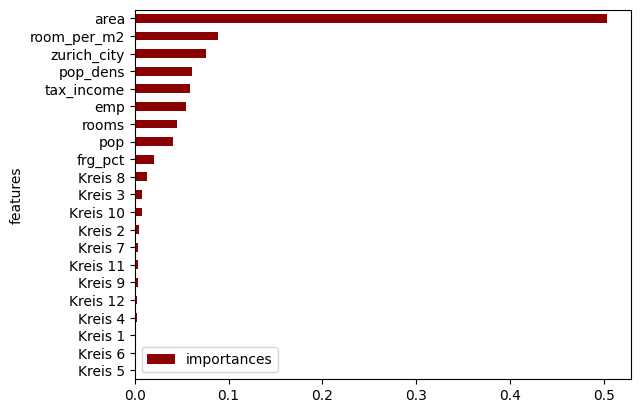

In [269]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

In [270]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'area_cat_ecoded', 'zurich_city']
model_performance(features, df)

CV results RMSE: [-651. -539. -700. -510. -561.]
Mean RMSE: -592.2


<Axes: ylabel='features'>

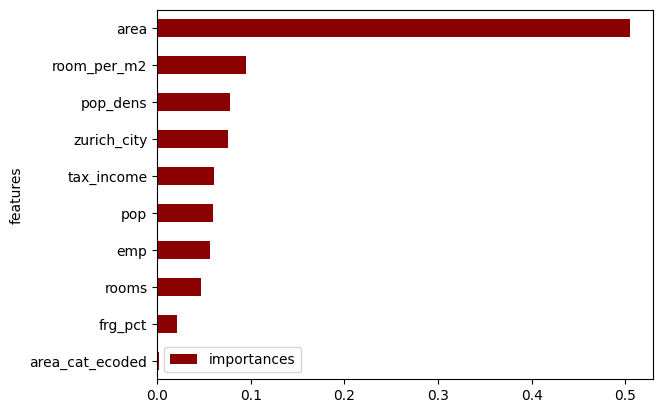

In [271]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

### Error analysis

In [272]:
# get all predictions for the training set.

# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

price_prediction = random_forest_model.predict(df[features])
df_with_residual = pd.DataFrame(df[features], columns=df[features].columns, copy=True)
df_with_residual['recidual (error)'] = np.abs(price_prediction - df.price)
df_with_residual['price'] = df.price
df_with_residual['predicted_price'] = price_prediction
print(df_with_residual.head())
# Add text, postalcode and town name
# we use join instead of merge, because we 'join' on the index column and do not perform a merge using a specific column
df_with_residual = df_with_residual.join(df[['description_raw', 'bfs_name', 'postalcode', 'town']])

   rooms  area    pop     pop_dens    frg_pct     emp  tax_income  \
0    3.0    49  12286  1221.272366  24.841283  5053.0       66676   
1    3.0   111  12286  1221.272366  24.841283  5053.0       66676   
2    3.0    58  12286  1221.272366  24.841283  5053.0       66676   
3    4.0   118  12286  1221.272366  24.841283  5053.0       66676   
4    3.0    66  12286  1221.272366  24.841283  5053.0       66676   

   room_per_m2  area_cat_ecoded  zurich_city  recidual (error)  price  \
0        16.33              0.0            0         55.220000   1441   
1        37.00              1.0            0         31.510000   2600   
2        19.33              2.0            0          8.712667   1490   
3        29.50              1.0            0         76.500000   3240   
4        22.00              2.0            0         41.740000   1450   

   predicted_price  
0      1496.220000  
1      2631.510000  
2      1481.287333  
3      3163.500000  
4      1491.740000  


In [273]:
# check which location has the largest errors.
df_with_residual[(df_with_residual['recidual (error)'] > 500)].groupby(['pop', 'bfs_name']).size().sort_values(ascending=False)

pop     bfs_name     
113173  Winterthur       8
50950   Zürich           4
41411   Zürich           3
78801   Zürich           3
17860   Zürich           2
29944   Zürich           2
39647   Zürich           2
59841   Zürich           2
27746   Dietikon         1
6485    Fehraltorf       1
13067   Zollikon         1
4840    Oetwil am See    1
16841   Wallisellen      1
35007   Uster            1
37639   Zürich           1
dtype: int64

In [274]:

df_with_residual[(df_with_residual['recidual (error)'] > 800)].to_csv('data_with_large_residuals.csv', 
          sep=",", 
          encoding='utf-8',
          index=False)

# School facility distances as a unique feature

## Import school facility data

In [287]:
df_schools = pd.read_json('schulanlagen_coordinates.json')
print(df_schools.head())

   longitude   latitude
0   8.488835  47.404463
1   8.488785  47.404930
2   8.488300  47.374165
3   8.488300  47.374165
4   8.522734  47.412016


## Map visualization

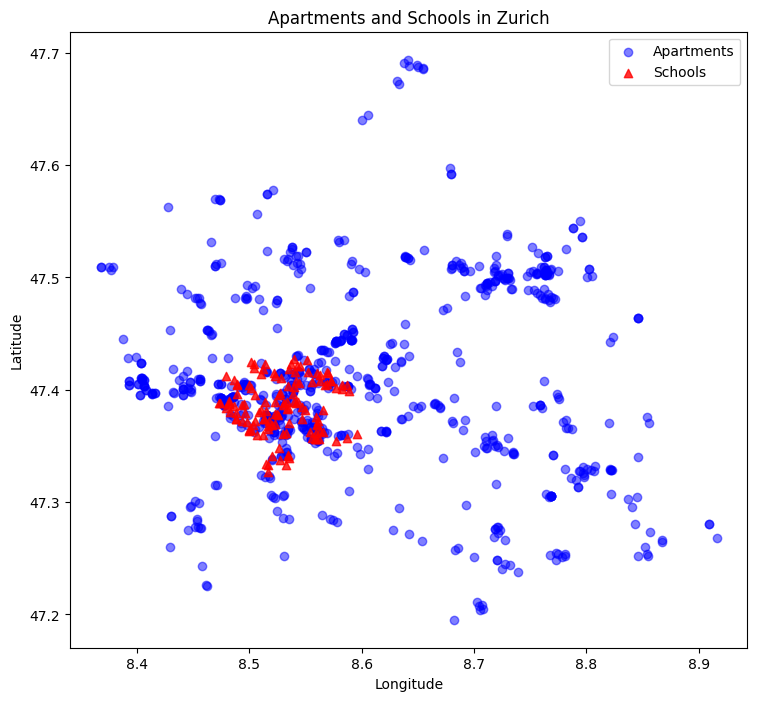

In [288]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_apartments = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
gdf_schools = gpd.GeoDataFrame(df_schools, geometry=gpd.points_from_xy(df_schools['longitude'], df_schools['latitude']))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf_apartments.plot(ax=ax, marker='o', color='blue', label="Apartments", alpha=0.5)
gdf_schools.plot(ax=ax, marker='^', color='red', label="Schools", alpha=0.8)

plt.title("Apartments and Schools in Zurich")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [290]:
import folium

# Define the center of the map (e.g., average location of apartments)
map_center = [df['lat'].mean(), df['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add apartment locations to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=4,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Apartment Price: {row['price']} CHF"
    ).add_to(m)

# Add school locations to the map
for _, row in df_schools.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color='red', icon='cloud'),
        popup="School"
    ).add_to(m)

# Show map
m


## Compute distance to nearest school

In [291]:
import numpy as np
import pandas as pd

# Define the Haversine function to compute distances
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km


In [292]:
def compute_nearest_school_distance(df, df_schools):
    distances = []
    
    for _, apt in df.iterrows():
        lat1, lon1 = apt['lat'], apt['lon']
        
        # Compute distances from this apartment to all schools
        school_distances = [
            haversine(lat1, lon1, school_lat, school_lon) 
            for school_lat, school_lon in zip(df_schools['latitude'], df_schools['longitude'])
        ]
        
        # Store the minimum distance (i.e., nearest school)
        distances.append(min(school_distances))

    # Add as a new feature
    df['distance_to_nearest_school'] = distances

    return df

# Apply function
df = compute_nearest_school_distance(df, df_schools)

# Show updated dataset
print(df[['lat', 'lon', 'distance_to_nearest_school']].head())


         lat       lon  distance_to_nearest_school
0  47.252167  8.845798                   22.377357
1  47.252087  8.854919                   22.963977
2  47.253670  8.853993                   22.811966
3  47.259834  8.851705                   22.311290
4  47.266113  8.866872                   22.977184


In [293]:
# Before unique feature addition RMSE: -584.2
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 
            'room_per_m2', 'area_cat_ecoded', 
            'zurich_city', 'distance_to_nearest_school'] 

# Train model again
model_performance(features, df)


CV results RMSE: [-612. -518. -661. -492. -533.]
Mean RMSE: -563.2


In [282]:
#df.to_csv('apartments_data_enriched_with_new_features.csv')

In [294]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

X = df[['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income',
        'room_per_m2', 'area_cat_ecoded', 'zurich_city', 'distance_to_nearest_school']]
y = df['price']

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R² Score: {r2}")


Test RMSE: 612.1235781096594
Test MAE: 430.62958943833945
Test R² Score: 0.499790789248614


In [295]:
# Initialize and train the model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predict on test data
y_pred = random_forest_model.predict(X_test)

# Evaluate performance (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Model RMSE: {rmse:.2f}")


Model RMSE: 612.12


In [296]:
import pickle

# Save trained model to a file
model_filename = "apartments.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)  # Replace 'rf_model' with your trained model
print(f"Model saved as {model_filename}")


Model saved as apartments.pkl


In [303]:
import gradio as gr
import pandas as pd
import pickle

# Load the trained model (if saved)
model_filename = "apartments.pkl"

try:
    with open(model_filename, "rb") as f:
        model = pickle.load(f)
except FileNotFoundError:
    print("Trained model not found. Ensure you save your model first.")

# Define the prediction function
def predict_price(rooms, area, pop, pop_dens, frg_pct, emp, tax_income, room_per_m2, 
                  area_cat_ecoded, zurich_city, distance_to_nearest_school):
    input_data = pd.DataFrame([[rooms, area, pop, pop_dens, frg_pct, emp, tax_income, 
                                room_per_m2, area_cat_ecoded, zurich_city, distance_to_nearest_school]],
                              columns=['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 
                                       'tax_income', 'room_per_m2', 'area_cat_ecoded', 
                                       'zurich_city', 'distance_to_nearest_school'])
    
    prediction = model.predict(input_data)[0]
    return f"Predicted Apartment Price: CHF {prediction:,.2f}"

# Create Gradio interface
demo = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Number of Rooms"),
        gr.Number(label="Area (m²)"),
        gr.Number(label="Population"),
        gr.Number(label="Foreign Percentage"),
        gr.Number(label="Taxable Income"),
        gr.Dropdown(label="Is the apartment in Zurich City?", choices=["Yes", "No"]),
        gr.Number(label="Distance to Nearest School (m)"),
    ],
    outputs="text",
    examples=[
        [3, 80, 50000, 1200, 30, 95, 75000, 0.04, 2, 1, 500],
        [4, 120, 70000, 1400, 25, 92, 90000, 0.033, 3, 0, 800],
        [2, 60, 40000, 1000, 35, 85, 60000, 0.05, 1, 1, 200]
    ],
    title="Apartment Price Prediction",
    description="Enter the apartment details to predict the estimated price in CHF."
)

# Launch Gradio App
demo.launch()

# Save model for future use
with open(model_filename, "wb") as f:
    pickle.dump(model, f)


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
